In [3]:
!pip install opencv-python
!pip install numpy
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.5 MB)
  Using cached numpy-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
  Using cached kiwisolver-1.4.7-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached pillow-10.4.0-cp310-cp310-manylinux_2_28_x86_64.whl (4.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 1.7 MB/s eta 0:00:0000:0100:010m
  Using cached contourpy-1.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (322 kB)


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


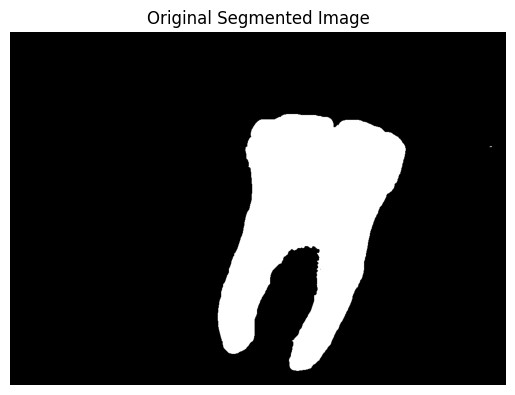

In [5]:
# Load the segmented image (binary mask)
# Replace 'segmented_image.png' with your actual file path
segmented_img = cv2.imread('mask_2.png', cv2.IMREAD_GRAYSCALE)

# Display the loaded image using Matplotlib
plt.imshow(segmented_img, cmap='gray')
plt.title('Original Segmented Image')
plt.axis('off')
plt.show()


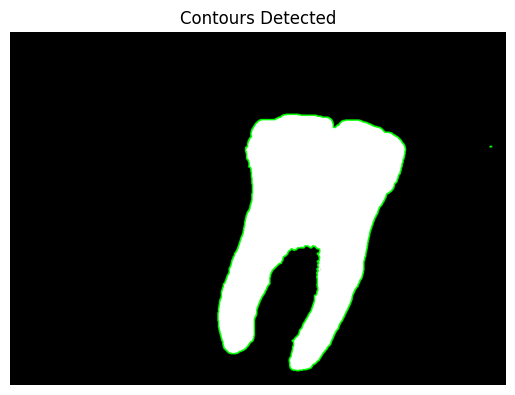

In [6]:
# Convert the image to binary using threshold (in case it's not binary)
_, binary_img = cv2.threshold(segmented_img, 127, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Visualize the detected contours
contour_img = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)  # Convert to BGR for visualization
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)  # Draw contours as green lines

# Plot the image with contours
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.title('Contours Detected')
plt.axis('off')
plt.show()

In [7]:
# Calculate Maximum Feret's Diameter
max_feret_diameter = 0
feret_pts = (None, None)  # To store the points corresponding to the max Feret's diameter

# Iterate through the contours (assuming only one main object)
for contour in contours:
    # Iterate over all possible pairs of contour points
    for i in range(len(contour)):
        for j in range(i + 1, len(contour)):
            point1 = contour[i][0]
            point2 = contour[j][0]
            
            # Calculate the Euclidean distance between point1 and point2
            distance = np.linalg.norm(point1 - point2)

            # Update max Feret diameter and store the points if the distance is greater
            if distance > max_feret_diameter:
                max_feret_diameter = distance
                feret_pts = (tuple(point1), tuple(point2))

# Print the results
print(f"Maximum Feret's Diameter: {max_feret_diameter}")
print(f"Endpoints of Maximum Feret's Diameter: {feret_pts}")


Maximum Feret's Diameter: 565.3635998187361
Endpoints of Maximum Feret's Diameter: ((np.int32(451), np.int32(662)), (np.int32(801), np.int32(218)))


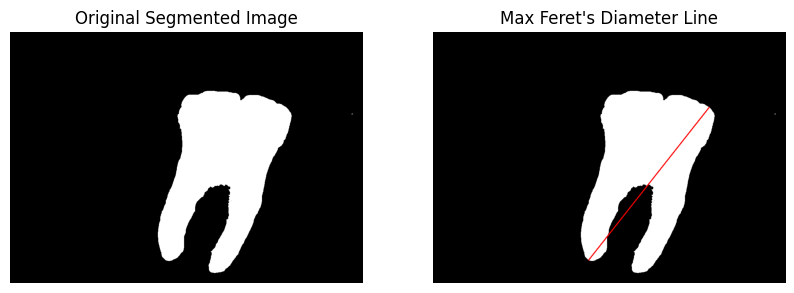

In [8]:
# Visualize the Maximum Feret's Diameter on the original image
result_img = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)  # Convert to a BGR image

# Draw the max Feret's diameter line (red color, thickness 2)
cv2.line(result_img, feret_pts[0], feret_pts[1], (0, 0, 255), 2)

# Plot the result side by side for comparison
plt.figure(figsize=(10, 5))

# Plot the original segmented image
plt.subplot(1, 2, 1)
plt.imshow(segmented_img, cmap='gray')
plt.title('Original Segmented Image')
plt.axis('off')

# Plot the result image with Max Feret's diameter line
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title("Max Feret's Diameter Line")
plt.axis('off')

plt.show()


In [17]:
# Ensure there is at least one contour with enough points to compute Feret's diameter and ellipse orientation
if len(contours) > 0 and len(contours[0]) >= 5:    
    # Already calculated Feret's maximum diameter points
    point1, point2 = feret_pts
    
    # Step 1: Calculate the center based on Feret's diameter endpoints (average of the two points)
    ellipse_center = (int((point1[0] + point2[0]) / 2), int((point1[1] + point2[1]) / 2))
    
    # Step 2: The major axis of the ellipse should be the maximum Feret's Diameter
    major_axis_length = int(max_feret_diameter)
    
    # Step 3: Minor axis is estimated as a fraction (~60%) of the bounding box height for now
    bounding_rect = cv2.boundingRect(contours[0])  # Get bounding box (x, y, width, height)
    minor_axis_length = max(int(bounding_rect[3] * 0.6), 10)  # Make sure it's not too small (e.g., at least 10 pixels)
    
    # Step 4: Calculate the orientation angle based on the Feret's diameter line
    # Using arctangent to calculate the angle from the Feret's diameter endpoints.
    angle = np.degrees(np.arctan2(point2[1] - point1[1], point2[0] - point1[0]))
    
    # Create a BGR image for visualization
    result_img_with_feret_ellipse = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)

    # Step 5: Draw the ellipse corresponding to Max Feret's diameter
    # Parameters: center, axes (major, minor), angle
    cv2.ellipse(
        result_img_with_feret_ellipse, 
        ellipse_center,                    # Center of ellipse
        (major_axis_length // 2, minor_axis_length // 2),  # Half-lengths for major and minor axes
        angle,                             # Orientation angle
        0, 360,                            # Full ellipse (0 to 360 degrees)
        (255, 0, 0),                        # Color (try RED for contrast)
        4                                   # Increased thickness to improve visibility
    )

else:
    print("Could not calculate Feret's ellipse. Contour may be too small or insufficient points.")


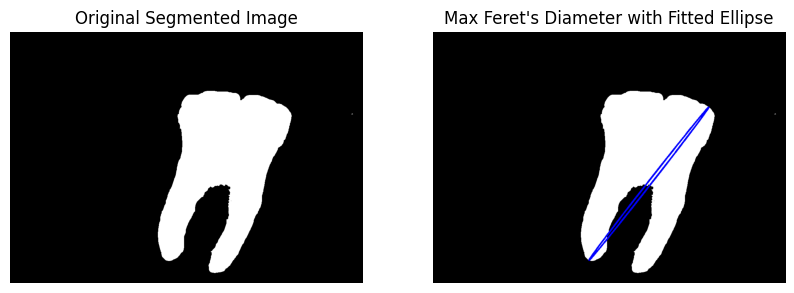

In [18]:
# Visualize the result: Original image with the Feret's ellipse and diameter
plt.figure(figsize=(10, 5))

# Plot the original segmented image
plt.subplot(1, 2, 1)
plt.imshow(segmented_img, cmap='gray')
plt.title('Original Segmented Image')
plt.axis('off')

# Plot the image with the Max Feret Diameter Line and the corresponding ellipse
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result_img_with_feret_ellipse, cv2.COLOR_BGR2RGB))
plt.title("Max Feret's Diameter with Fitted Ellipse")
plt.axis('off')

plt.show()
